In [1]:
using CSV, DataFrames, Dates, Plots

# Dados da pandemia de COVID-19 no Rio de Janeiro


- Os dados obtidos em [1] foram tratados no notebook  TratamentoDadosCovidRJ.ipynb .


- Após carregar os dados, precisamos selecionar um ou mais períodos para modelar.

[1] https://www.data.rio/datasets/PCRJ::cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro-1/about

In [2]:
df = DataFrame(CSV.File("DadosMedia.csv"))

datasTudo = df[:,"DatasMedia"]
infTudo = df[:,"InfectadosMedia"]
recTudo = df[:,"RecuperadosMedia"]
decTudo = df[:,"ObitosMedia"]

limiteE = findall(data->data==Date(2020,03,18),datasTudo)[1]
limiteD = findall(data->data==Date(2020,06,30),datasTudo)[1]

datasOnda = datasTudo[limiteE:limiteD]
infOnda = infTudo[limiteE:limiteD]
recOnda = recTudo[limiteE:limiteD]
decOnda = decTudo[limiteE:limiteD]

dadosOnda = hcat(infOnda,recOnda,decOnda)

nothing

In [3]:
expIniciais = 2000.
astIniciais = 1000.
reaIniciais = 100.

u₀_SEIAR  = [expIniciais,infOnda[1],astIniciais,recOnda[1],reaIniciais,decOnda[1]]
θs₀_SEIAR = [6_000_000, 1., 1., 0.1, 0.05, 0.05, 1.]

u₀_SIRD  = [infOnda[1], recOnda[1], decOnda[1]]
θs₀_SIRD = [50_000, 0.5, 0.5, 0.5]

nothing

# Ajustando uma *Universal Ordinary Differential Equation*

In [4]:
using DiffEqFlux, DifferentialEquations.OrdinaryDiffEq, Optim, Random; include("AuxMisc.jl")

## Ajuste para dados dos $N$ primeiros dias

- Vamos ajustar os parâmetros do modelo *UODE* utilizando somente os dados dos $N$ primeiros dias para testar sua capacidade de previsão.

In [5]:
N = 70

function φ(x)
    return max(0, min(x, 1))
end

function dudtSIR!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R
    β, γ_R, γ_D = θ

    E_novos = β^2 * I*S / N
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

u₀ = u₀_SIRD
θs₀_SIR = θs₀_SIRD # θs = [S₀; θ]
indModelo = [2, 3, 4]
iterSIR = 10^4

dadosTreino = dadosOnda[1:N, :]    
dadosTreinoT = dadosTreino'

# AJUSTE SIR:    
modeloSIR(θs) = solve(ODEProblem(dudtSIR!, [θs[1]; u₀], (1., N), θs[2:end]), saveat = 1)[indModelo, :]

custoSIR(θs) = sum(abs2, dadosTreinoT .- modeloSIR(θs))

θs₁ = Optim.minimizer(optimize(custoSIR, θs₀_SIR, iterations = iterSIR))
S₀_SIR = θs₁[1]
θ₁_SIR = θs₁[2:end]

3-element Vector{Float64}:
 0.37990354361670714
 0.20039276392775995
 0.07767545526167374

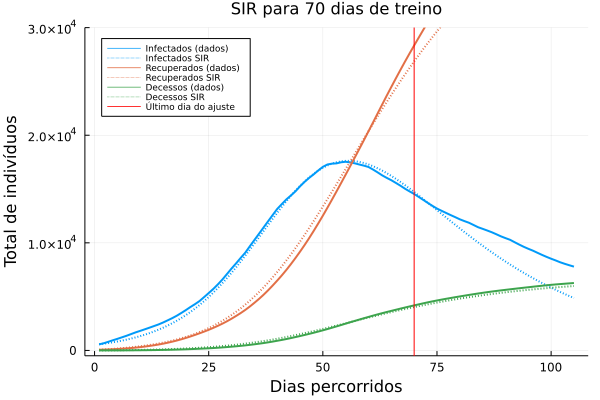

In [6]:
resultSIR = solve(ODEProblem(dudtSIR!, [S₀_SIR; u₀], (1., size(dadosOnda)[1]), θ₁_SIR), saveat = 1)

infSIR = resultSIR[indModelo[1], :]
recSIR = resultSIR[indModelo[2], :]
decSIR = resultSIR[indModelo[3], :]

pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1)
plot!(pl, infSIR, label = "Infectados SIR", lw = 2, linestyle = :dot, color = 1)

plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2)
plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, linestyle = :dot, color = 2)

plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3)
plot!(pl, decSIR, label = "Decessos SIR", lw = 2, linestyle = :dot, color = 3)

plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl, title = "SIR para $N dias de treino", titlefont = 11 , ylim = (-500, 30000),
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

pl

In [7]:
fatorReducao = maximum(dadosTreino)
dadosTreinoT = dadosTreinoT ./ fatorReducao
u₀ = u₀ ./ fatorReducao
S₀_SIR = S₀_SIR / fatorReducao

1.8813354413623329

In [8]:
NN = FastChain(FastDense(2,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)
inputVectorSizeNN = 2

numDataPoints = 200
Xs = rand(inputVectorSizeNN, numDataPoints)
#Xs = rand(inputVectorSizeNN, numDataPoints) .* max(1., S₀_SIR)

func(X) = θ₁_SIR[1]^2 * X[1]*X[2]

data_func = [func(X) for X in eachcol(Xs)]

function costNN(θ)
    pred = [NN(X, θ)[1] for X in eachcol(Xs)]
    return sum(abs2, data_func .- pred), pred
end

costsNN = []

function callBackNN(θ, cost, pred)
    push!(costsNN, cost)
    if length(costsNN) % 50 == 0
        println("Iteracao : ", length(costsNN), " , Erro : ", SciRound(cost))
    end
    false
end

resultBFGS = DiffEqFlux.sciml_train(costNN, initial_params(NN), cb = callBackNN, BFGS(initial_stepnorm = 0.01),
    maxiters = 500, allow_f_increases = true)
#resultBFGS = DiffEqFlux.sciml_train(costNN, initial_params(NN), cb = callBackNN, BFGS(initial_stepnorm = 0.01),
#    maxiters = 1_000, allow_f_increases = true)
θ₀_NN = resultBFGS.minimizer

Iteracao : 50 , Erro : 4.30e-4
Iteracao : 100 , Erro : 3.07e-4
Iteracao : 150 , Erro : 1.82e-4
Iteracao : 200 , Erro : 3.18e-5
Iteracao : 250 , Erro : 1.21e-5
Iteracao : 300 , Erro : 8.13e-6
Iteracao : 350 , Erro : 6.57e-6
Iteracao : 400 , Erro : 4.59e-6
Iteracao : 450 , Erro : 4.10e-6
Iteracao : 500 , Erro : 2.65e-6


337-element Vector{Float32}:
 -0.23472668
  0.85327536
 -0.71642953
 -0.17178318
 -0.2084681
 -1.0364099
  1.7118877
  0.59176284
  0.3842743
  0.48795313
 -0.25188428
 -0.65313417
 -0.13872993
  ⋮
 -0.41651538
 -0.21714899
 -1.1454667
 -0.07869857
  0.16598648
  0.50349164
 -0.42662936
 -0.19115464
 -0.36132506
 -1.0976831
 -0.6586697
 -2.9525218

In [9]:
numeroParametrosNN = length(initial_params(NN))

function dudtUODE!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R
    γ_R, γ_D = θ[1:2]

    E_novos =  NN([S/N, I], θ[3:end])[1]
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

custosUODE = []

function callBackUODE(θ, custo, previsao)
    push!(custosUODE, custo)
    if length(custosUODE)%10 == 0
        println("Iteracao : ", length(custosUODE), " , Erro : ", SciRound(custo))
    end
    false
end

θ₀_UODE = [θ₁_SIR[2:end]; θ₀_NN]
problemaUODE = ODEProblem(dudtUODE!, [S₀_SIR; u₀], (1.,N), θ₀_UODE)

function custoUODE(θ)
    previsao = concrete_solve(problemaUODE, Vern7(), [S₀_SIR; u₀], θ, saveat = 1, abstol = 1e-4, reltol = 1e-4,
        sensealg = InterpolatingAdjoint(autojacvec = ReverseDiffVJP()))[indModelo, :]
    custo = sum(abs2, dadosTreinoT .- previsao)
    return custo, previsao
end

c = custoUODE(θ₀_UODE)[1]

0.0422072810081463

In [10]:
custosUODE = []

resultadoBFGS_UODE = DiffEqFlux.sciml_train(custoUODE, θ₀_UODE, cb = callBackUODE, BFGS(initial_stepnorm = 0.01),
    maxiters = 250, allow_f_increases = true)
θ₁_UODE = resultadoBFGS_UODE

Iteracao : 10 , Erro : 3.95e-2
Iteracao : 20 , Erro : 3.93e-2
Iteracao : 30 , Erro : 3.93e-2
Iteracao : 40 , Erro : 3.92e-2
Iteracao : 50 , Erro : 3.92e-2
Iteracao : 60 , Erro : 3.92e-2
Iteracao : 70 , Erro : 3.92e-2
Iteracao : 80 , Erro : 3.92e-2
Iteracao : 90 , Erro : 3.92e-2
Iteracao : 100 , Erro : 3.92e-2
Iteracao : 110 , Erro : 3.92e-2
Iteracao : 120 , Erro : 3.92e-2
Iteracao : 130 , Erro : 3.92e-2
Iteracao : 140 , Erro : 3.92e-2
Iteracao : 150 , Erro : 3.92e-2
Iteracao : 160 , Erro : 3.92e-2
Iteracao : 170 , Erro : 3.92e-2


u: 339-element Vector{Float64}:
  0.200748961663283
  0.07774118800920726
 -0.2332327165175363
  0.8669499685756479
 -0.7107263988963921
 -0.23809271190205022
 -0.21141088298921754
 -1.0356458716748635
  1.708721442808267
  0.5960930242044548
  0.3693834393525113
  0.48726388375039503
 -0.22420115156739778
  ⋮
 -0.41937271834713
 -0.16951208225900463
 -1.1626355508908133
 -0.08204321152134665
  0.15906451305664424
  0.49837212230489775
 -0.44783061029867915
 -0.2152582647842102
 -0.36973367427383047
 -1.1146938183918098
 -0.6499393263402679
 -2.9456575058574863

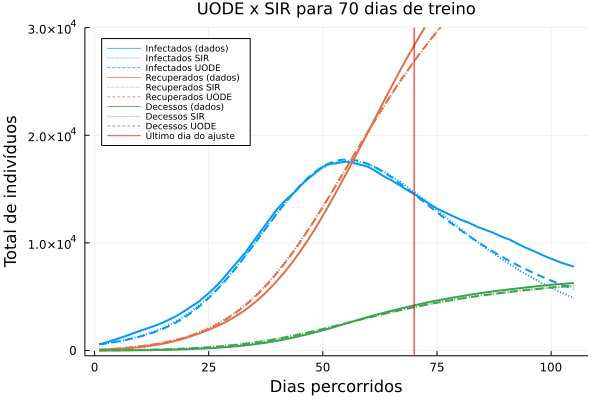

In [11]:
#modeloUODE = solve(ODEProblem(dudtUODE!, [S₀_SIR; u₀], (1., size(dadosOnda)[1]), θ₀_UODE), saveat = 1)[indModelo, :]' .* fatorReducao
modeloUODE = solve(ODEProblem(dudtUODE!, [S₀_SIR; u₀], (1., size(dadosOnda)[1]), θ₁_UODE), saveat = 1)[indModelo, :]' .* fatorReducao

infUODE = modeloUODE[:, 1]
recUODE = modeloUODE[:, 2]
decUODE = modeloUODE[:, 3]

pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1)
plot!(pl, infSIR, label = "Infectados SIR", lw = 2, linestyle = :dot, color = 1)
plot!(pl, infUODE, label = string("Infectados UODE"), lw = 2, linestyle = :dash, color = 1)

plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2)
plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, linestyle = :dot, color = 2)
plot!(pl, recUODE, label = string("Recuperados UODE"), lw = 2, linestyle = :dash, color = 2)

plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3)
plot!(pl, decSIR, label = "Decessos SIR", lw = 2, linestyle = :dot, color = 3)
plot!(pl, decUODE, label = string("Decessos UODE"), lw = 2, linestyle = :dash, color = 3)

plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl, title = "UODE x SIR para $N dias de treino", titlefont = 11 , ylim = (-500, 30000),
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

display(pl)

In [12]:
c_initSIR = DataFrame(:S0 => S₀_SIR)
paramsSIR = DataFrame(:Parametros => θ₁_SIR)

paramsUODE = DataFrame(:Parametros => θ₁_UODE)

CSV.write(string("Parametros_SIRD_UODE_bSI/c_initSIRD_", N, "Dias.csv"), c_initSIR)
CSV.write(string("Parametros_SIRD_UODE_bSI/paramsSIRD_", N, "Dias.csv"), paramsSIR)

CSV.write(string("Parametros_SIRD_UODE_bSI/paramsSIRD_UODE_bSI_", N, "Dias.csv"), paramsUODE)

"Parametros_SIRD_UODE_bSI/paramsSIRD_UODE_bSI_70Dias.csv"